# Car Type Classification Project

## Overview
This project aims to classify car types using images from the **Stanford Cars Dataset**. The dataset contains **16,185 images** across **196 classes**, with annotations for bounding boxes, class labels, and human-readable car names. For this project, we will focus on identifying the **car type** (e.g., sedan, suv, truck) from the images.

---

## Dataset Information
- **Source:** [Stanford Cars Dataset](http://ai.stanford.edu/~jkrause/cars/car_dataset.html)
- **Contents:** Images of cars with labels for brand, model, year, and bounding boxes.
- **Focus:** The `true_class_name` column will be split to extract the car's `vehicle_type` for classification.

---

## Goal
Develop a machine learning model that accurately predicts car types from images. This project serves as a foundation for further exploration, such as identifying car models or other attributes.


In [ ]:
# Import Tools
import datetime
import os
import pickle
import itertools
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras as tf_keras
from tf_keras.src.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

## Data Exploration

In [ ]:
# get csv file with labels
file_path = '/content/drive/MyDrive/Cars/Cars_Data_11.csv'

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,x1,y1,x2,y2,class,true_class_name,brand,model,vehicle_type,year,image
0,0,39,116,569,375,14,Audi TTS Coupe 2012,Audi,TTS,Coupe,2012.0,00001.jpg
1,1,36,116,868,587,3,Acura TL Sedan 2012,Acura,TL,Sedan,2012.0,00002.jpg
2,2,85,109,601,381,91,Dodge Dakota Club Cab 2007,Dodge,Dakota,Truck,2007.0,00003.jpg
3,3,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,Hyundai,Sonata Hybrid,Sedan,2012.0,00004.jpg
4,4,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,Ford,F-450,Truck,2012.0,00005.jpg


In [ ]:
# List all unique values in the 'vehicle_type' column
unique_types = df['vehicle_type'].unique()
print(unique_types)

['Coupe' 'Sedan' 'Truck' 'Convertible' 'SUV' 'Minivan' 'Hatchback' 'Van'
 'Wagon']


Unnamed: 0                                      2221
x1                                                29
y1                                                66
x2                                               597
y2                                               228
class                                             59
true_class_name    Chevrolet Camaro Convertible 2012
brand                                      Chevrolet
model                                         Camaro
vehicle_type                             Convertible
year                                          2012.0
image                                      02222.jpg
Name: 2221, dtype: object


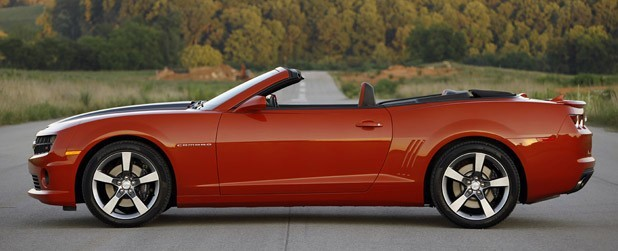

In [ ]:
# Example row and pic
print(df.iloc[2221])
Image('/content/drive/MyDrive/Cars/cars_train/cars_train/02222.jpg')

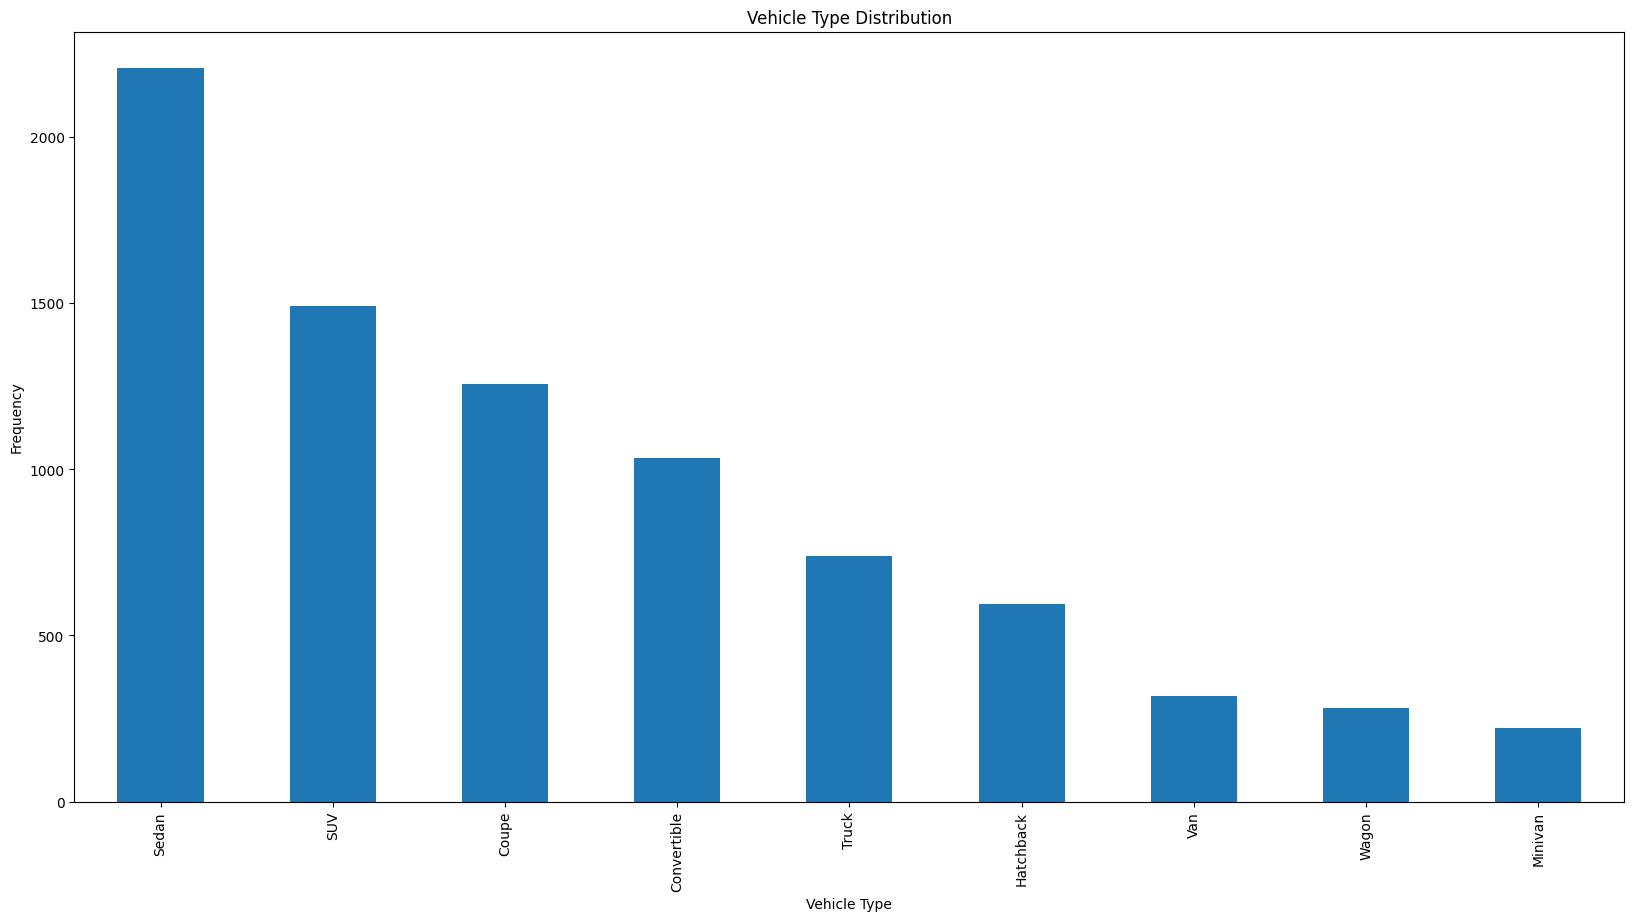

In [ ]:
# Graph the Vehicle Type Distribution
df['vehicle_type'].value_counts().plot.bar(
    figsize=(20, 10),
    title="Vehicle Type Distribution"
)

plt.xlabel("Vehicle Type")
plt.ylabel("Frequency")
plt.show()

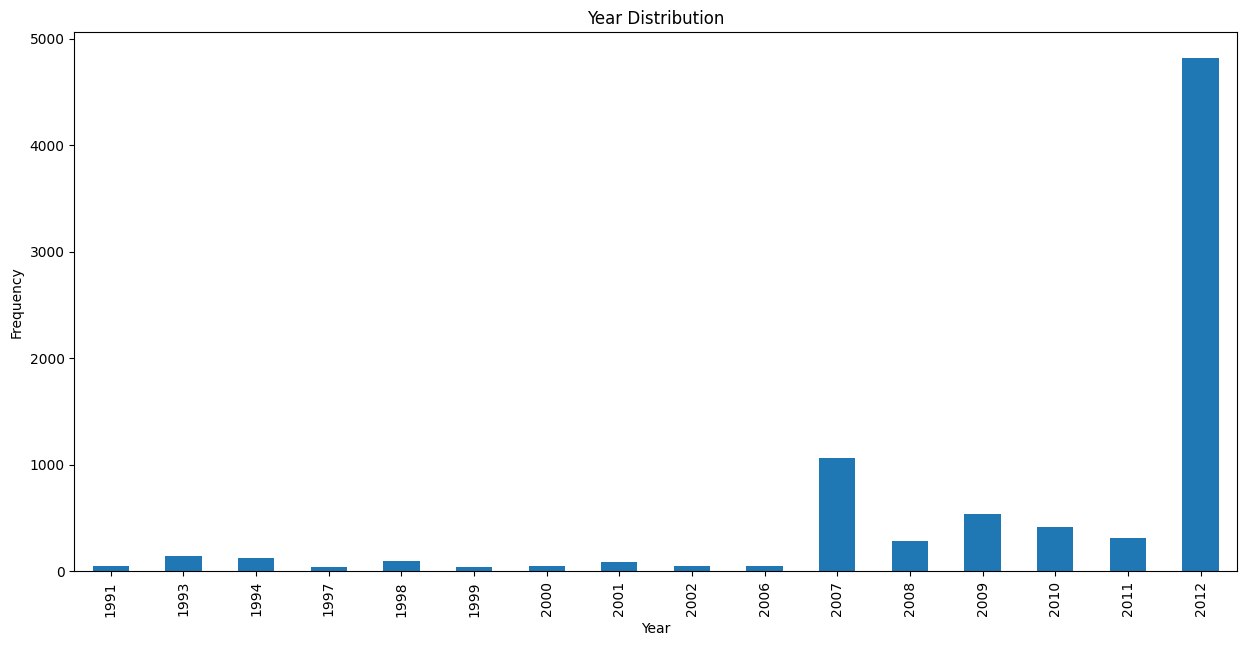

In [ ]:
# Graph the year distribution
df['year'].dropna().astype(int).value_counts().sort_index().plot.bar(figsize=(15, 7), title="Year Distribution")

plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

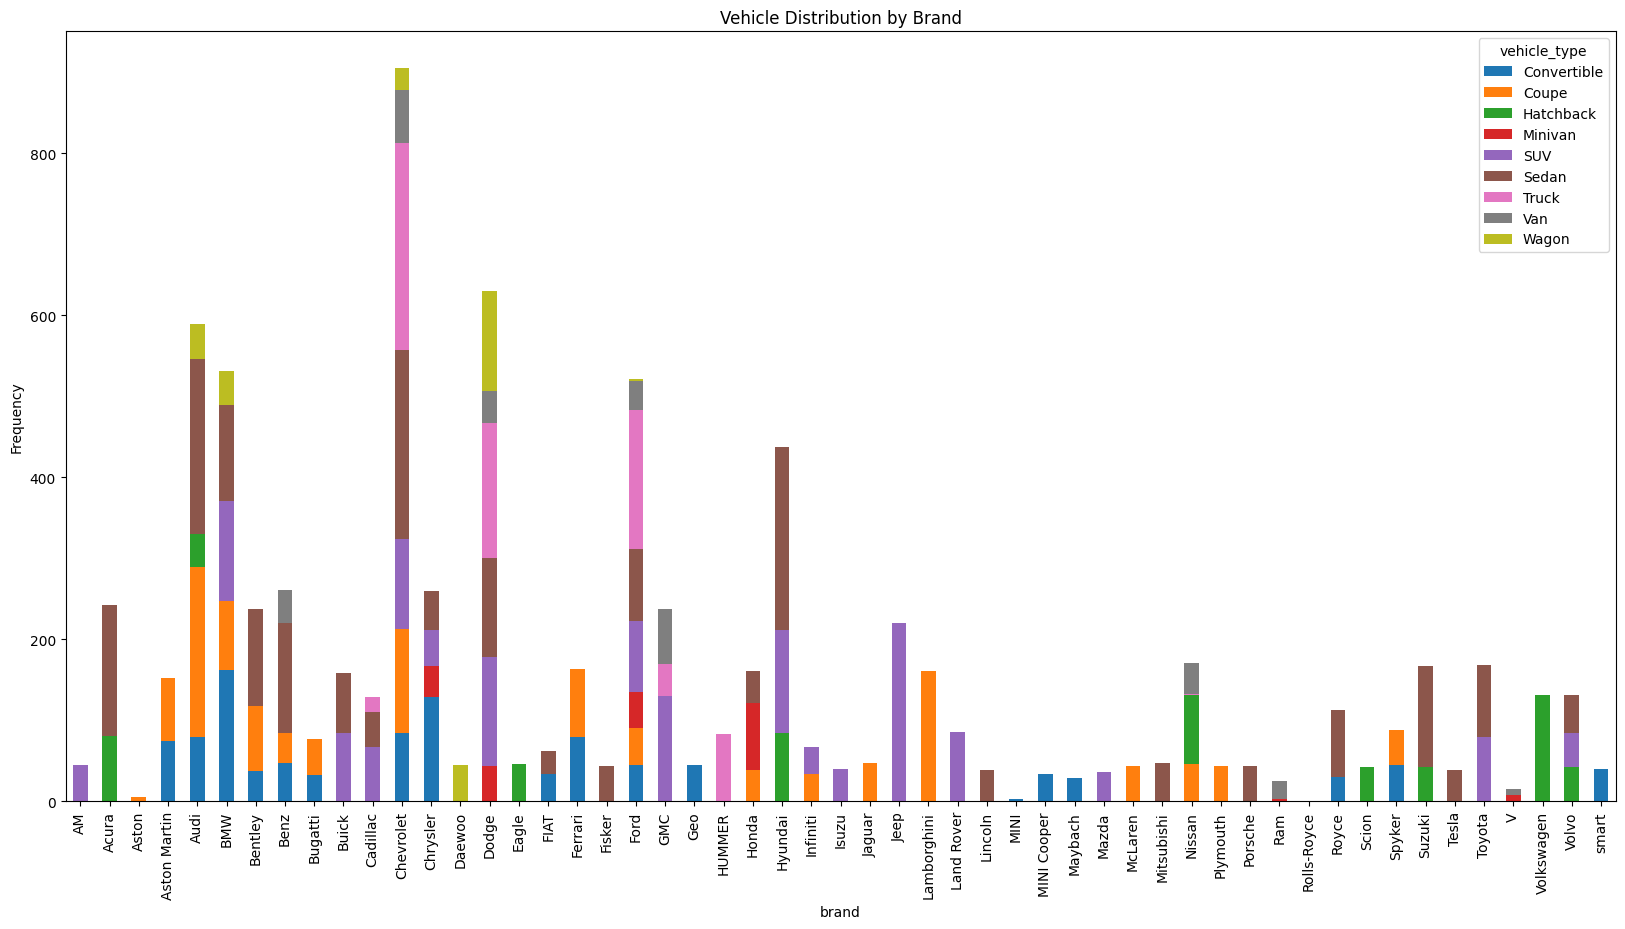

In [ ]:
# Graph the vehicle distribution by the brand
brand_make_distribution = df.groupby('brand')['vehicle_type'].value_counts().unstack().fillna(0)
brand_make_distribution.plot(kind='bar', stacked=True, figsize=(20, 10), title="Vehicle Distribution by Brand")

plt.ylabel("Frequency")
plt.show()

## Data Preparation

In [ ]:
# assign labels_csv to pandas datafrane from csv
labels_csv = pd.read_csv("/content/drive/MyDrive/Cars/Cars_Data_11.csv")
print(labels_csv.describe())
print(labels_csv.head())

        Unnamed: 0           x1           y1           x2           y2  \
count  8144.000000  8144.000000  8144.000000  8144.000000  8144.000000   
mean   4071.500000    64.906803   108.661223   638.208620   416.431606   
std    2351.114629    82.198684   104.551635   410.776734   273.786000   
min       0.000000     1.000000     1.000000    76.000000    47.000000   
25%    2035.750000    19.000000    42.000000   392.000000   248.000000   
50%    4071.500000    39.000000    80.000000   569.000000   360.000000   
75%    6107.250000    79.000000   138.250000   746.250000   477.000000   
max    8143.000000  1648.000000  1508.000000  5205.000000  3389.000000   

             class         year  
count  8144.000000  8141.000000  
mean     98.979371  2009.560496  
std      56.503148     4.435914  
min       1.000000  1991.000000  
25%      50.000000  2008.000000  
50%      99.000000  2012.000000  
75%     148.000000  2012.000000  
max     196.000000  2012.000000  
   Unnamed: 0   x1   y1    

In [ ]:
labels_csv["vehicle_type"].value_counts().median()

738.0

In [ ]:
# filenames for image path
base_path = '/content/drive/MyDrive/Cars/cars_train/cars_train/'
filenames = df['image'].apply(lambda x: base_path + x).to_numpy()

filenames[:10]

array(['/content/drive/MyDrive/Cars/cars_train/cars_train/00001.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00002.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00003.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00004.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00005.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00006.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00007.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00008.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00009.jpg',
       '/content/drive/MyDrive/Cars/cars_train/cars_train/00010.jpg'],
      dtype=object)

In [ ]:
# assign label to list of vehicle type for each instance
labels = labels_csv["vehicle_type"]
labels = np.array(labels)
labels

array(['Coupe', 'Sedan', 'Truck', ..., 'Coupe', 'Coupe', 'Sedan'],
      dtype=object)

In [ ]:
# turn a single label into an array of booleans
print(labels[0])
vehicle_type = np.unique(labels)
labels[0] == vehicle_type

Coupe


array([False,  True, False, False, False, False, False, False, False])

In [ ]:
# turn every label to bool label
boolean_labels = [label == np.array(vehicle_type) for label in labels]
boolean_labels[:5]

[array([False,  True, False, False, False, False, False, False, False]),
 array([False, False, False, False, False,  True, False, False, False]),
 array([False, False, False, False, False, False,  True, False, False]),
 array([False, False, False, False, False,  True, False, False, False]),
 array([False, False, False, False, False, False,  True, False, False])]

### Split data to train, validation, and test

In [ ]:
# Setup X and Y variables
X = filenames
y = boolean_labels

Experiment with 1000 images



In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:500, max:8000, step:500}
NUM_IMAGES


# Split them into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = .2,
                                                  random_state = 42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocess Images

In [ ]:
image = imread(filenames[1])
image.shape

(675, 900, 3)

In [ ]:
IMG_SIZE = 224

# turn images to tensors
def process_images(image_path):
  '''
  Takes a list of image file paths and turns the images into tensors.
  '''
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
# return tuple of images and label
def get_image_label(image_path, label):
  image = process_images(image_path)
  return image, label

In [ ]:
# create data batches functions

def create_data_batches(X, y=None, batch_size=32, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths (no labels)
    data_batch = data.map(process_images).batch(batch_size)
    return data_batch

  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    #Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(batch_size)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train, batch_size = 32)
val_data = create_data_batches(X_val, y_val, valid_data=True, batch_size = 32)
print(train_data.element_spec, val_data.element_spec)

Creating training data batches...
Creating validation data batches...
(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.bool, name=None)) (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.bool, name=None))


In [ ]:
print(vehicle_type)

['Convertible' 'Coupe' 'Hatchback' 'Minivan' 'SUV' 'Sedan' 'Truck' 'Van'
 'Wagon']


## Build Model

In [ ]:
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=9, learning_rate=0.001):
    # Load MobileNetV2 base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=9, learning_rate=0.001):
    # Load ResNet50V2 base model
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
patience = 5 #@param {type:"slider", min:1, max:20, step:1}

early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = patience)

In [ ]:
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Cars/Logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf_keras.callbacks.TensorBoard(logdir)

In [ ]:
# Build a function to train and return a trained model
def train_model(num_epochs, model_type, val_data, train_data, learning_rate=0.001, drop_rate=0.2, isFinal = False):
  # Create a model
  if model_type == "resnet":
    model = create_resnet_model(learning_rate=learning_rate)
  elif model_type == "mobilenet":
    model = create_mobilenet_model(learning_rate=learning_rate)
  elif model_type == "dropout":
    model = create_resnet_model_dropout(drop_rate=drop_rate)
  elif model_type == "l2":
    model = create_resnet_model_l2()


  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  if(isFinal):
    model.fit(x=train_data,
          epochs=num_epochs,
          validation_data=None,
          validation_freq=1,
          callbacks=[full_model_tensorboard, full_model_early_stopping])
  else:
    model.fit(x=train_data,
        epochs=num_epochs,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
mobilenet_model = train_model(num_epochs=25, model_type="mobilenet", val_data=val_data, train_data=train_data, learning_rate=0.001)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3520 - loss: 1.8335 - val_accuracy: 0.5350 - val_loss: 1.2201
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6623 - loss: 0.9440 - val_accuracy: 0.5500 - val_loss: 1.2255
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7484 - loss: 0.7528 - val_accuracy: 0.5900 - val_loss: 1.2256
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8104 - loss: 0.5736 - val_accuracy: 0.5450 - val_loss: 1.2489
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8470 - loss: 0.5142 - val_accuracy: 0.5850 - val_loss: 1.2036
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8865 - loss: 0.3623 - val_accuracy: 0.5300 - val_loss: 1.2629
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9351 - loss: 0.3184 - val_accuracy: 0.5800 - val_loss: 1.1932
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 

In [ ]:
resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data, train_data=train_data, learning_rate=0.001)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.3935 - loss: 1.7826 - val_accuracy: 0.5650 - val_loss: 1.2777
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6744 - loss: 0.9870 - val_accuracy: 0.6350 - val_loss: 1.2058
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7873 - loss: 0.6700 - val_accuracy: 0.6600 - val_loss: 1.1019
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8372 - loss: 0.5138 - val_accuracy: 0.6450 - val_loss: 1.1450
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8635 - loss: 0.4481 - val_accuracy: 0.6200 - val_loss: 1.3511
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9055 - loss: 0.3355 - val_accuracy: 0.6500 - val_loss: 1.1427
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9570 - loss: 0.2197 - val_accuracy: 0.6500 - val_loss: 1.1251
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accur

In [ ]:
test_loss, test_accuracy = mobilenet_model.evaluate(val_data)
print(f"Mobilenet Test Accuracy: {test_accuracy:.2f}")

test_loss, test_accuracy = resnet_model.evaluate(val_data)
print(f"Resnet Test Accuracy: {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6004 - loss: 1.4184
Mobilenet Test Accuracy: 0.60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6098 - loss: 1.2850
Resnet Test Accuracy: 0.64


## Optimize Model

In [ ]:
train_data_16_batch = create_data_batches(X_train, y_train, batch_size = 16)
val_data_16_batch = create_data_batches(X_val, y_val, valid_data=True, batch_size = 16)
train_data_64_batch = create_data_batches(X_train, y_train, batch_size = 64)
val_data_64_batch = create_data_batches(X_val, y_val, valid_data=True, batch_size = 64)

Creating training data batches...
Creating validation data batches...
Creating training data batches...
Creating validation data batches...


In [ ]:
resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_16_batch, train_data=train_data_16_batch, learning_rate=0.001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_16_batch)
print(f"Resnet 16 Batch Test Accuracy: {test_accuracy:.2f}")

resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_64_batch, train_data=train_data_64_batch, learning_rate=0.001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_64_batch)
print(f"Resnet 64 Batch Test Accuracy: {test_accuracy:.2f}")

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.3876 - loss: 1.8368 - val_accuracy: 0.5950 - val_loss: 1.3386
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6749 - loss: 0.9939 - val_accuracy: 0.5400 - val_loss: 1.2410
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7601 - loss: 0.7718 - val_accuracy: 0.6150 - val_loss: 1.1266
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8440 - loss: 0.5109 - val_accuracy: 0.6350 - val_loss: 1.1584
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8685 - loss: 0.4493 - val_accuracy: 0.6250 - val_loss: 1.1211
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5921 - loss: 1.1792
Resnet 16 Batch Test Accuracy: 0.62
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 691ms/step - accuracy: 0.3379 - loss: 1.9528 - val_accuracy: 0.4500 - val_loss: 1.4680
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5941 - loss: 1.1643 - val_accuracy: 0.5650 - val_loss: 1.2

In [ ]:
# Experiment with different batch sizes
for batch_size in [8, 16, 24, 32, 48, 64, 128]:
    print(f"\nTesting batch size: {batch_size}")

    # Create training and validation data batches
    train_data_batch = create_data_batches(X_train, y_train, batch_size=batch_size)
    val_data_batch = create_data_batches(X_val, y_val, valid_data=True, batch_size=batch_size)

    resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_batch, train_data=train_data_batch, learning_rate=0.001)

    # Evaluate the model
    test_loss, test_accuracy = resnet_model.evaluate(val_data_batch)
    print(f"Batch size: {batch_size} - Validation Accuracy: {test_accuracy:.2f}")


Testing batch size: 8
Creating training data batches...
Creating validation data batches...
Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.3685 - loss: 1.7591 - val_accuracy: 0.6150 - val_loss: 1.1767
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7089 - loss: 0.8411 - val_accuracy: 0.6100 - val_loss: 1.1458
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7736 - loss: 0.6874 - val_accuracy: 0.6250 - val_loss: 1.2017
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8742 - loss: 0.4411 - val_accuracy: 0.6450 - val_loss: 1.3043
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8896 - loss: 0.3756 - val_accuracy: 0.6550 - val_loss: 1.1996
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6189 - loss: 1.3576
Batch size: 8 - Validation Accuracy: 0.65

Testing batch size: 16
Creating training data batches...
Creating validation data batches...
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/ste

In [ ]:
resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_16_batch, train_data=train_data_16_batch, learning_rate=0.0001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_16_batch)
print(f"Batch size: 16, Learning Rate: 0.0001 - Validation Accuracy: {test_accuracy:.2f}")

resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_batch, train_data=train_data_batch, learning_rate=0.0001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_batch)
print(f"Batch size: 32, Learning Rate: 0.0001 - Validation Accuracy: {test_accuracy:.2f}")

resnet_model = train_model(num_epochs=25, model_type="resnet", val_data=val_data_64_batch, train_data=train_data_64_batch, learning_rate=0.0001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_64_batch)
print(f"Batch size: 64, Learning Rate: 0.0001 - Validation Accuracy: {test_accuracy:.2f}")

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.2295 - loss: 2.0750 - val_accuracy: 0.4450 - val_loss: 1.5889
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5168 - loss: 1.4654 - val_accuracy: 0.5000 - val_loss: 1.4360
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6130 - loss: 1.2707 - val_accuracy: 0.5350 - val_loss: 1.3597
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6586 - loss: 1.0493 - val_accuracy: 0.5650 - val_loss: 1.2695
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7361 - loss: 0.8927 - val_accuracy: 0.5650 - val_loss: 1.2348
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5323 - loss: 1.2781
Batch size: 16, Learning Rate: 0.0001 - Validation Accuracy: 0.56
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2623 - loss: 2.1153 - val_accuracy: 0.2900 - val_loss: 1.9036
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.3119 - loss: 1.8590 - val_accuracy:

In [ ]:
def create_resnet_model_dropout(input_shape=(224, 224, 3), num_classes=9, learning_rate=0.001, drop_rate=0.5):
    # Load ResNet50V2 base model
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add custom layers with dropout
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = Dropout(drop_rate)(x)  # Add dropout
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
for drop_rate in [0.2, 0.3, 0.4, 0.5]:
    print(f"\nTesting Dropout: {drop_rate}")

    # Create training and validation data batches
    train_data_batch = create_data_batches(X_train, y_train, batch_size=32)
    val_data_batch = create_data_batches(X_val, y_val, valid_data=True, batch_size=32)

    resnet_model = train_model(num_epochs=25, model_type="dropout", val_data=val_data_batch, train_data=train_data_batch, learning_rate=0.001, drop_rate=drop_rate)

    # Evaluate the model
    test_loss, test_accuracy = resnet_model.evaluate(val_data_batch)
    print(f"Dropout: {drop_rate} - Validation Accuracy: {test_accuracy:.2f}")


Testing Dropout: 0.2
Creating training data batches...
Creating validation data batches...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.3363 - loss: 2.0135 - val_accuracy: 0.5600 - val_loss: 1.2857
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6222 - loss: 1.0926 - val_accuracy: 0.6050 - val_loss: 1.1200
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7005 - loss: 0.8530 - val_accuracy: 0.6350 - val_loss: 1.1062
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7532 - loss: 0.7461 - val_accuracy: 0.6150 - val_loss: 1.0779
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7824 - loss: 0.6191 - val_accuracy: 0.6550 - val_loss: 1.1238
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6133 - loss: 1.2252
Dropout: 0.2 - Validation Accuracy: 0.65

Testing Dropout: 0.3
Creating training data batches...
Creating validation data batches...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0

In [ ]:
def create_resnet_model_l2(input_shape=(224, 224, 3), num_classes=9, learning_rate=0.001):
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Add custom layers with L2 regularization
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
resnet_model = train_model(num_epochs=25, model_type="l2", val_data=val_data_batch, train_data=train_data_batch, learning_rate=0.001)
test_loss, test_accuracy = resnet_model.evaluate(val_data_batch)
print(f"Validation Accuracy: {test_accuracy:.2f}")

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.3758 - loss: 1.9946 - val_accuracy: 0.4800 - val_loss: 1.4734
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6670 - loss: 1.1716 - val_accuracy: 0.6100 - val_loss: 1.3157
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7611 - loss: 0.8631 - val_accuracy: 0.6100 - val_loss: 1.2936
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7997 - loss: 0.7548 - val_accuracy: 0.6150 - val_loss: 1.3649
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8693 - loss: 0.6113 - val_accuracy: 0.6100 - val_loss: 1.3172
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5644 - loss: 1.4110
Validation Accuracy: 0.61


In [ ]:
def preprocess_and_augment(image_path, label):
    image = tf.io.read_file(image_path)                        # Read image file
    image = tf.image.decode_jpeg(image, channels=3)            # Decode JPEG
    image = tf.image.resize(image, [224, 224])                 # Resize to 224x224
    image = tf.image.random_flip_left_right(image)             # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)   # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    image = image / 255.0                                      # Normalize
    return image, label

In [ ]:
# Create a tf.data dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data_augmented = train_dataset.map(preprocess_and_augment).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
resnet_model = train_model(
    num_epochs=25,
    model_type="resnet",
    val_data=val_data,              # Use preprocessed validation data
    train_data=train_data_augmented,  # Use augmented training data
    learning_rate=0.001
)

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(val_data)
print(f"ResNet Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 362ms/step - accuracy: 0.3361 - loss: 1.9442 - val_accuracy: 0.5500 - val_loss: 1.2725
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.6171 - loss: 1.0425 - val_accuracy: 0.6300 - val_loss: 1.1189
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.7235 - loss: 0.8073 - val_accuracy: 0.6550 - val_loss: 1.1408
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.7820 - loss: 0.6602 - val_accuracy: 0.6250 - val_loss: 1.2093
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.8152 - loss: 0.5290 - val_accuracy: 0.6550 - val_loss: 1.1335
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6169 - loss: 1.2398
ResNet Test Accuracy: 0.6550, Test Loss: 1.1335


In [ ]:
resnet_model = train_model(
    num_epochs=25,
    model_type="resnet",
    val_data=val_data,              # Use preprocessed validation data
    train_data=train_data,  # Use augmented training data
    learning_rate=0.001
)

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(val_data)
print(f"ResNet Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.3580 - loss: 1.8354 - val_accuracy: 0.5550 - val_loss: 1.3206
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6528 - loss: 0.9753 - val_accuracy: 0.6200 - val_loss: 1.2105
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7452 - loss: 0.7296 - val_accuracy: 0.6100 - val_loss: 1.2366
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8271 - loss: 0.5698 - val_accuracy: 0.6100 - val_loss: 1.2521
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8531 - loss: 0.4592 - val_accuracy: 0.6000 - val_loss: 1.1948
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5653 - loss: 1.2612
ResNet Test Accuracy: 0.6000, Test Loss: 1.1948


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'batch_size': [32, 48, 64],
    'dropout_rate': [0.2, 0.3, 0.5]
}

In [ ]:
# Grid search implementation
best_params = None
best_val_accuracy = 0
results = []

# Generate all combinations of parameters
param_combinations = list(itertools.product(
    param_grid['learning_rate'],
    param_grid['batch_size'],
    param_grid['dropout_rate']
))

# Iterate through each combination
for lr, batch_size, dropout_rate in param_combinations:
    print(f"Testing: Learning Rate={lr}, Batch Size={batch_size}, Dropout={dropout_rate}")

    # Create training and validation data batches
    train_data_batch = create_data_batches(X_train, y_train, batch_size=batch_size)
    val_data_batch = create_data_batches(X_val, y_val, valid_data=True, batch_size=batch_size)

    # Create and train the model
    def create_resnet_model_with_dropout(input_shape=(224, 224, 3), num_classes=9, learning_rate=0.001, dropout_rate=0.5):
        base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
        base_model.trainable = False

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

        model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    model = create_resnet_model_with_dropout(learning_rate=lr, dropout_rate=dropout_rate)

    # Train the model
    history = model.fit(
        train_data_batch,
        validation_data=val_data_batch,
        epochs=10,  # Keep small epochs for faster testing
        verbose=1
    )

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(val_data_batch)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Store results
    results.append((lr, batch_size, dropout_rate, val_accuracy, val_loss))

    # Update best parameters
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = {'learning_rate': lr, 'batch_size': batch_size, 'dropout_rate': dropout_rate}

# Output the best parameters
print("\nBest Parameters:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

Testing: Learning Rate=0.001, Batch Size=32, Dropout=0.2
Creating training data batches...
Creating validation data batches...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.3084 - loss: 2.0739 - val_accuracy: 0.5250 - val_loss: 1.3570
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6074 - loss: 1.1700 - val_accuracy: 0.5700 - val_loss: 1.3190
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6860 - loss: 0.8919 - val_accuracy: 0.6200 - val_loss: 1.1495
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.7387 - loss: 0.7674 - val_accuracy: 0.6300 - val_loss: 1.1730
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8037 - loss: 0.5879 - val_accuracy: 0.6300 - val_loss: 1.1906
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8300 - loss: 0.5208 - val_accuracy: 0.6150 - val_loss: 1.1475
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8884 - loss: 0.4284 - val_accuracy: 0.6400 -

In [ ]:
# Define the path to save the results in Google Drive
save_path = '/content/drive/MyDrive/Cars/grid_search_results.csv'

# Convert the results to a DataFrame and save
results_df = pd.DataFrame(results, columns=['learning_rate', 'batch_size', 'dropout_rate', 'val_accuracy', 'val_loss'])
results_df.to_csv(save_path, index=False)

print(f"Grid search results saved to {save_path}")


#### Best Parameters:
{'learning_rate': 0.001, 'batch_size': 32, 'dropout_rate': 0.3}
Best Validation Accuracy: 0.6750

## Train Full Model

In [ ]:
len(X), len(y)

In [ ]:
full_train_data = create_data_batches(X, y, batch_size=32)

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf_keras.callbacks.EarlyStopping(monitor="accuracy",
                                                              patience=3)

In [ ]:
final_model = train_model(
    num_epochs=50,                  # Train for more epochs
    model_type="dropout",            # ResNet architecture
    val_data=None,         # Validation data
    train_data=full_train_data,     # Full training data
    learning_rate=0.001,            # Best learning rate
    drop_rate=0.3,                   # Best dropout rate
    isFinal=True
)

Epoch 1/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.4741 - loss: 1.5032
Epoch 2/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6280 - loss: 1.0097
Epoch 3/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6717 - loss: 0.9086
Epoch 4/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6977 - loss: 0.8101
Epoch 5/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7297 - loss: 0.7404
Epoch 6/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7458 - loss: 0.6996
Epoch 7/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7519 - loss: 0.6541
Epoch 8/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7911 - loss: 0.5919
Epoch 9/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7968 - loss: 0.5495
Epoch 10/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8091 - loss: 0.5197
Epoch 11/50
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8272 - loss: 0.4762
Epoch 12/50
255/255 ━━━━━━━━━━━

In [ ]:
def save_model_to_drive(model, folder_name, base_drive_path='/content/drive/MyDrive/Cars/Models'):
    """
    Save a Keras model in all supported formats to a specified folder in Google Drive.

    Args:
    - model: The Keras model to be saved.
    - folder_name: Name of the folder to save the model in (will be created if it doesn't exist).
    - base_drive_path: The base path for saving in Google Drive (default: My Drive in Colab).
    """
    # Create the save folder in Google Drive
    save_path = os.path.join(base_drive_path, folder_name)
    os.makedirs(save_path, exist_ok=True)
    print(f"Saving model to: {save_path}")

    # Save in Keras native format (.keras)
    keras_path = os.path.join(save_path, 'model.keras')
    model.save(keras_path)
    print(f"Model saved in Keras format: {keras_path}")

    # Save in HDF5 format (.h5)
    hdf5_path = os.path.join(save_path, 'model.h5')
    model.save(hdf5_path)
    print(f"Model saved in HDF5 format: {hdf5_path}")

    # Export to TensorFlow SavedModel format
    tf_saved_model_path = os.path.join(save_path, 'saved_model')
    model.export(tf_saved_model_path)
    print(f"Model exported in TensorFlow SavedModel format: {tf_saved_model_path}")

        # Save as Pickle (.pkl)
    pickle_path = os.path.join(save_path, 'model.pkl')
    with open(pickle_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved in Pickle format: {pickle_path}")

In [ ]:
save_model_to_drive(final_model, 'final_resnet_model_1')

Saving model to: /content/drive/MyDrive/Cars/Models/final_resnet_model_1


Model saved in Keras format: /content/drive/MyDrive/Cars/Models/final_resnet_model_1/model.keras
Model saved in HDF5 format: /content/drive/MyDrive/Cars/Models/final_resnet_model_1/model.h5
Saved artifact at '/content/drive/MyDrive/Cars/Models/final_resnet_model_1/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_9453')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  131968169740064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131965596074576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131970384023392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131960142510416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131960142508832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131960142507600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131960142603616: TensorSpec(shape=(), dtype=tf.r

In [ ]:
def load_model(model_path):
    """
    Loads a saved model from a specified .h5 file path.

    Args:
    - model_path: Path to the saved .h5 model file.

    Returns:
    - model: The loaded Keras model.
    """
    print(f"Loading saved model from: {model_path}")
    try:
        # Load the model
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={"KerasLayer": tf.keras.layers.Layer}
        )
        print("Model loaded successfully.")
        return model
    except Exception as e:
        print(f"Failed to load model. Error: {e}")
        return None

In [ ]:
full_model = load_model('/content/drive/MyDrive/Cars/Models/final_resnet_model_1/model.h5')

Loading saved model from: /content/drive/MyDrive/Cars/Models/final_resnet_model_1/model.h5


Model loaded successfully.


## Testing on Custom Images

In [ ]:
# Path to your custom images
custom_path = "/content/drive/MyDrive/Cars/Car_Images"

# Get file paths for all images in the folder
custom_image_paths = [os.path.join(custom_path, fname) for fname in os.listdir(custom_path)]
print(custom_image_paths)
len(custom_image_paths)

['/content/drive/MyDrive/Cars/Car_Images/download-24.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-12.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-11.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-10.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-21.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-16.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-20.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-14.jpg', '/content/drive/MyDrive/Cars/Car_Images/images-2.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-19.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-18.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-15.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-9.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-23.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-26.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-25.jpg', '/content/drive/MyDrive/Cars/Car_Images/download-30.jpg', '/content/drive/M

36

In [ ]:
# Use your existing create_data_batches function for custom images
custom_data = create_data_batches(custom_image_paths, test_data=True)  # Assuming test_data=True processes without labels

Creating test data batches...


In [ ]:
# Predict on custom images
custom_preds = full_model.predict(custom_data)

# Check the predictions
print(custom_preds.shape)  # Should match (number of images, number of classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step
(36, 9)


In [ ]:
# Map predictions to their labels
def get_pred_label(pred):
    return vehicle_type[np.argmax(pred)]

# Generate labels for each prediction
custom_pred_labels = [get_pred_label(pred) for pred in custom_preds]
print(custom_pred_labels)

['SUV', 'Sedan', 'Sedan', 'Sedan', 'Sedan', 'Truck', 'Convertible', 'Truck', 'Truck', 'Convertible', 'Convertible', 'Truck', 'Sedan', 'SUV', 'SUV', 'SUV', 'Hatchback', 'Sedan', 'Minivan', 'SUV', 'Coupe', 'Sedan', 'Sedan', 'Sedan', 'Hatchback', 'Van', 'Sedan', 'Van', 'Sedan', 'Sedan', 'Van', 'Van', 'Coupe', 'Convertible', 'Coupe', 'Sedan']


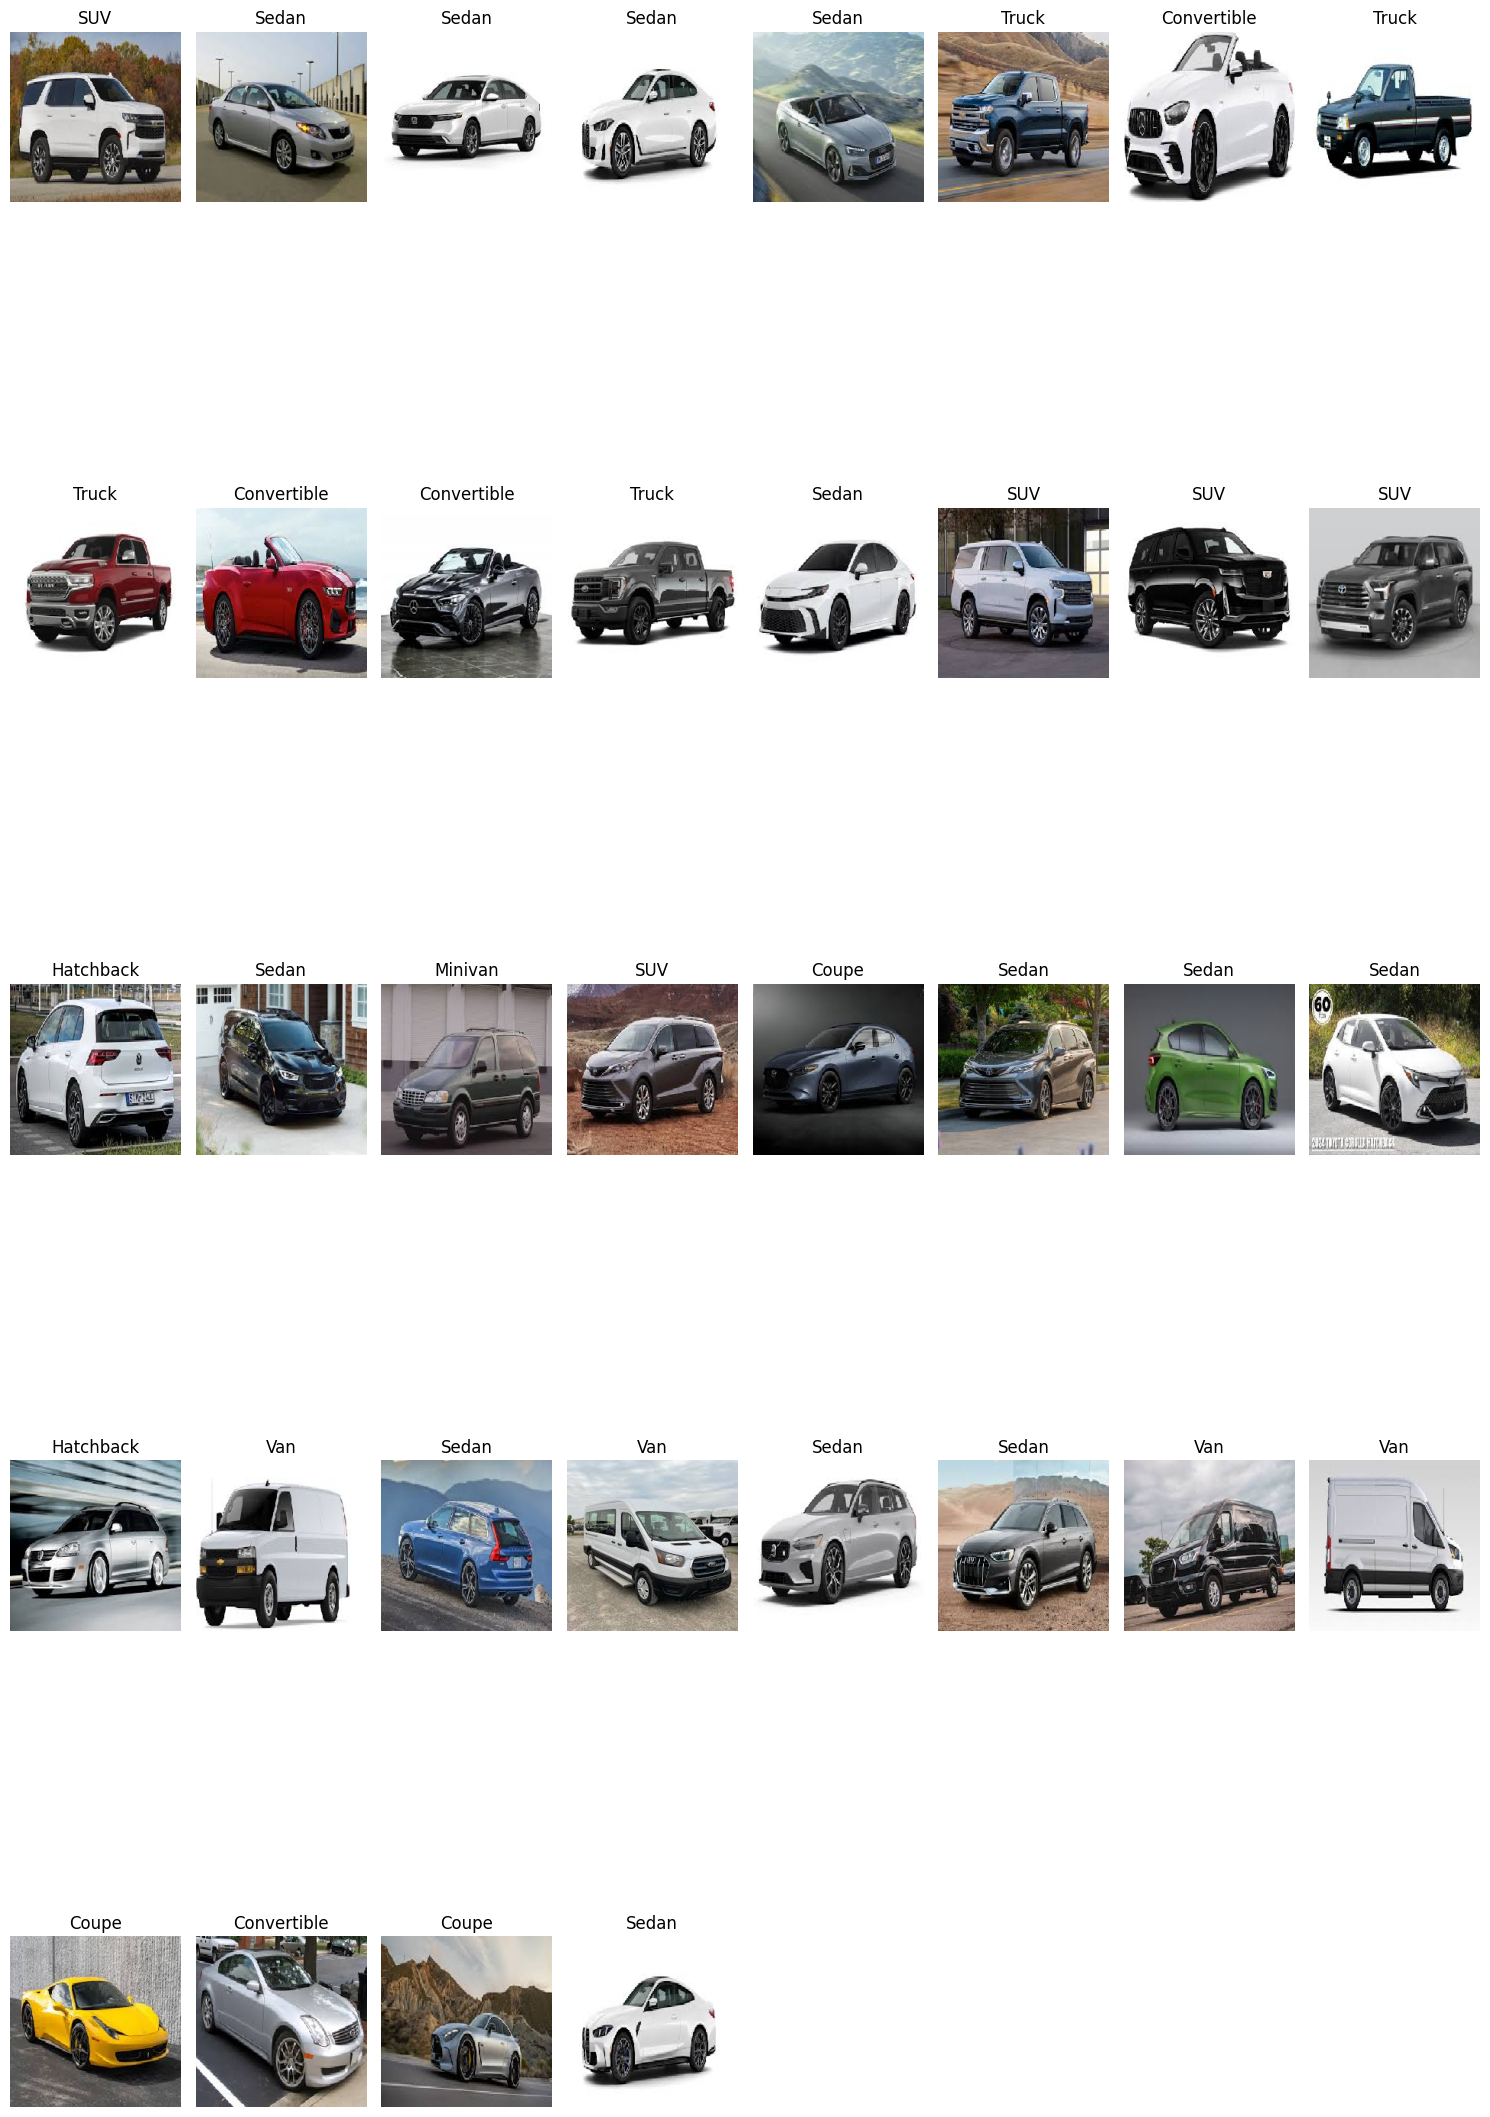

In [ ]:
# Load the original images for visualization
custom_images = [load_img(path, target_size=(224, 224)) for path in custom_image_paths]

# Define the number of images per row
images_per_row = 8
n_rows = (len(custom_images) + images_per_row - 1) // images_per_row  # Calculate total rows needed

# Plot the images with their predicted labels
plt.figure(figsize=(15, 5 * n_rows))  # Adjust figure size based on rows
for i, image in enumerate(custom_images):
    plt.subplot(n_rows, images_per_row, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(custom_pred_labels[i])
plt.tight_layout()
plt.show()